### PREDICTION OF ACCIDENTS in UK 2019 USING EDA , DATA MINING , MACHINE LEARNING

#### IMPORTING LIBRARIES

In [1]:
#Libraries for eda
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as gp
import numpy as np
import plotly.express as px
import calendar
import seaborn as sns
import random
import plotly as py
#Kmeans & PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

#Associate rule mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from functools import reduce

#MODEL TRAIN & TEST
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import log_loss
from sklearn import metrics
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
import sys
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Defining path variables
Accidents = '../data/Accidents2019.csv'
Vehicles = '../data/Vehicles2019.csv'
Casualities = '../data/Casualties2019.csv'
cas = '../data/cas2019.csv'

In [3]:
df1 = pd.read_csv(Accidents,dtype={'Accident_Index': str},parse_dates=["Date"])
df2 = pd.read_csv(Vehicles,dtype={'Accident_Index': str})
df3 = pd.read_csv(Casualities,dtype={'Accident_Index': str})
df4 = pd.read_csv(cas,dtype={'accident_index': str})

#### DATA CLEANING 

I have obtained the local authority districts of the nan values and find the mean of locations_easting_osgr,Location_Northing_OSGR,latitude and longitude so the values wont be drastically changing as its based on the same district values. 

In [4]:
loc_east = df1['Location_Easting_OSGR'][df1['Local_Authority_(District)'][df1['Location_Easting_OSGR'].isnull()]].mean()
loc_north = df1['Location_Northing_OSGR'][df1['Local_Authority_(District)'][df1['Location_Easting_OSGR'].isnull()]].mean()
long = df1['Longitude'][df1['Local_Authority_(District)'][df1['Longitude'].isnull()]].mean()
lat = df1['Latitude'][df1['Local_Authority_(District)'][df1['Latitude'].isnull()]].mean()
time = df1['Time'].value_counts().index.tolist()[0]
df1['Location_Easting_OSGR'] = df1['Location_Easting_OSGR'].fillna(loc_east)
df1['Location_Northing_OSGR'] = df1['Location_Northing_OSGR'].fillna(loc_north)
df1['LSOA_of_Accident_Location'] = df1['LSOA_of_Accident_Location'].fillna('Unknown')
df1['Time'] = df1['Time'].fillna(time)

In [5]:
accident= df1[['Accident_Index', 'Longitude', 'Latitude', 'Accident_Severity', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 
              'Road_Type', 'Speed_limit', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 
              'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 
              'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident']].copy()

vehicles = df2[['Accident_Index', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?', 
                'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver','Age_Band_of_Driver', 
                'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Driver_Home_Area_Type']].copy()

casuality = df3[['Accident_Index', 'Casualty_Class', 'Casualty_Severity', 'Casualty_Type']].copy()

acc_df = accident.merge(vehicles,on='Accident_Index').merge(casuality,on='Accident_Index')

In [6]:
def hour(string):
    s=string[0:2]
    return int(s)
acc_df['hrs']=acc_df['Time'].apply(lambda x: hour(x))
acc_df['Date'] = pd.to_datetime(acc_df['Date'], errors='coerce')
acc_df['dayofyear'] = acc_df['Date'].dt.dayofyear
acc_df['weekofyear'] = acc_df['Date'].dt.isocalendar().week
acc_df['monthofyear'] = acc_df['Date'].dt.month

#### EXPLORATORY DATA ANALYSIS

#### (a) Are there significant hours of the day, and days of the week, on which accidents occur?

##### Hours: 

Peak hours 15:00-17:00 in the evening seems to have more accidents as per the graph
##### Days : 

270's and 350's days have more number accidents as there will be more travelers during those period of time

##### Months: 

April -Easter holiday - Sunday had a spike in accidents  ,September,October & December could be seen with higher number of accidents

In [7]:
hrs_mean = acc_df['hrs'].mean()
hrs_std = acc_df['hrs'].std()
stdplus = hrs_mean + hrs_std
stdminus = hrs_mean - hrs_std

AxesSubplot(0.125,0.125;0.775x0.755)


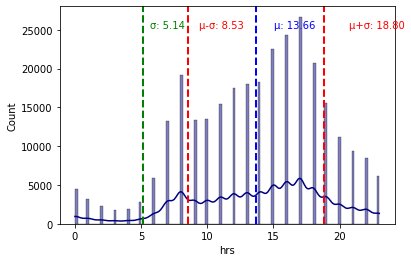

In [8]:
%matplotlib inline
hrs_acc = sns.histplot(x=acc_df['hrs'], kde=True, color='navy')
plt.axvline(hrs_mean, color='blue', ls='--', lw=2)
min_ylim, max_ylim = plt.ylim()
plt.text(hrs_mean*1.1, max_ylim*0.9, 'μ: {:.2f}'.format(hrs_mean), color='blue')
plt.axvline(hrs_std, color='green', ls='--', lw=2)
plt.text(hrs_std*1.1, max_ylim*0.9, 'σ: {:.2f}'.format(hrs_std), color='green')
plt.axvline(stdplus, color='red', ls='--', lw=2)
min_ylim, max_ylim = plt.ylim()
plt.text(stdplus*1.1, max_ylim*0.9, 'μ+σ: {:.2f}'.format(stdplus), color='red')
plt.axvline(stdminus, color='red', ls='--', lw=2)
plt.text(stdminus*1.1, max_ylim*0.9, 'μ-σ: {:.2f}'.format(stdminus), color='red')
print(hrs_acc)

AxesSubplot(0.125,0.125;0.775x0.755)


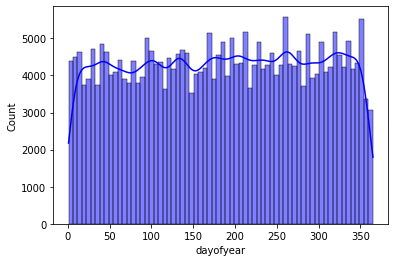

In [9]:
%matplotlib inline
dy = sns.histplot(acc_df['dayofyear'], kde=True, color='blue')
print(dy)

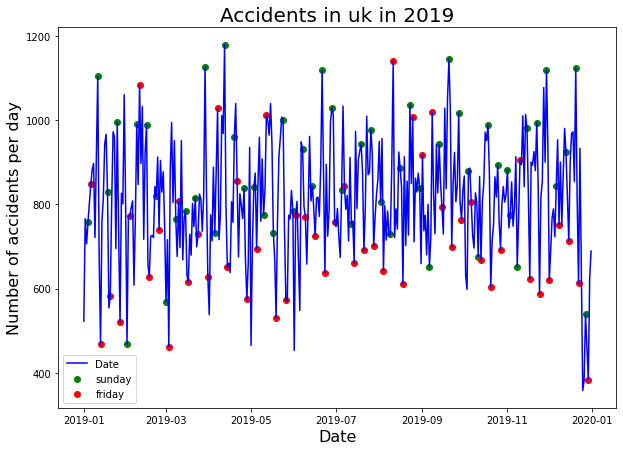

In [10]:
accidents = acc_df.groupby(acc_df['Date'].dt.date).count().Date
accidents.plot(figsize=(10,7), color='blue')
# sunday accidents
sundays = acc_df.groupby(acc_df[acc_df['Date'].dt.dayofweek==4].Date.dt.date).count().Date
plt.scatter(sundays.index, sundays, color='green', label='sunday')
# friday accidents
friday = acc_df.groupby(acc_df[acc_df['Date'].dt.dayofweek==6].Date.dt.date).count().Date
plt.scatter(friday.index, friday, color='red', label='friday')
# Title, x label and y label
plt.title('Accidents in uk in 2019', fontsize=20)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Number of accidents per day',fontsize=16);
plt.legend()

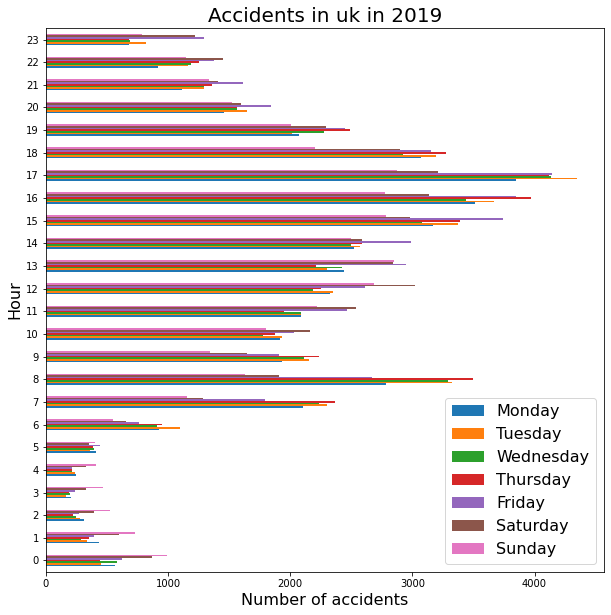

In [64]:
%matplotlib inline
# Number of accident per hour and day
accidents_hour_day = acc_df['hrs'].groupby([acc_df['hrs'],acc_df['Date'].dt.dayofweek.rename('day')]).count()
accidents_hour_day
accidents_hour_day.unstack().plot(kind='barh', figsize=(10,10))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=16)
plt.title('Accidents in uk in 2019',fontsize=20)
plt.xlabel('Number of accidents',fontsize=16)
plt.ylabel('Hour',fontsize=16);

#### (b) For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?

Motorcycle over 500cc are most likely to be too old

Motorcycle 125cc and under are facing more accidents

##### Hours : 
most of the motors are likely to crash around the peak hours morning 8:00 & at evenings 15:00-18:00

##### days of the week : 
Friday , Satuday are the busy days of the week as people tend to travel a lot during weekends 

Motorcycle over 500cc & Motorcycle 125cc and under are facing more accidents and vechicles are too older


In [12]:
vehicle_type={1:'Pedal cycle',
2:'Motorcycle 50cc and under',
3:'Motorcycle 125cc and under',
4:'Motorcycle over 125cc and up to 500cc',
5:'Motorcycle over 500cc',
8:'Taxi/Private hire car',
9:'Car',
10:'Minibus (8 - 16 passenger seats)',
11:'Bus or coach (17 or more pass seats)',
16:'Ridden horse',
17:'Agricultural vehicle',
18:'Tram',
19:'Van / Goods 3.5 tonnes mgw or under',
20:'Goods over 3.5t. and under 7.5t',
21:'Goods 7.5 tonnes mgw and over',
22:'Mobility scooter',
23:'Electric motorcycle',
90:'Other vehicle',
97:'Motorcycle - unknown cc',
98:'Goods vehicle - unknown weight',
-1:'Data Missing'
}
acc_df['Vehicle_Type']=acc_df.Vehicle_Type.map(vehicle_type)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

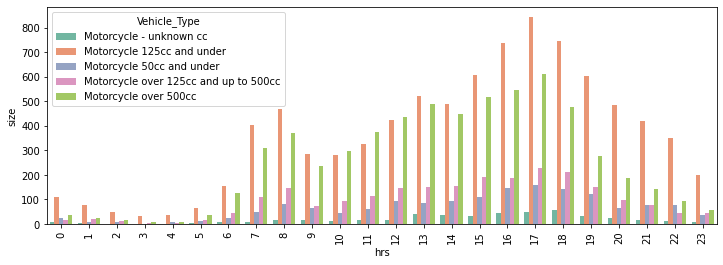

In [13]:
motorhrs = pd.DataFrame(acc_df.groupby([acc_df['Vehicle_Type'][acc_df['Vehicle_Type'].str.contains('Motorcycle')],acc_df['hrs']], as_index=False).size())
plt.figure(figsize=(12,4))
sns.barplot(x='hrs',data=motorhrs,y='size', hue='Vehicle_Type', palette='Set2')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

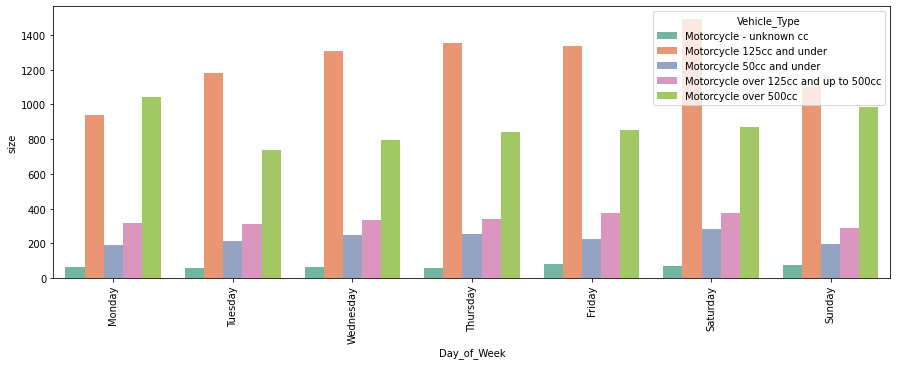

In [14]:
motordays = pd.DataFrame(acc_df.groupby([acc_df['Vehicle_Type'][acc_df['Vehicle_Type'].str.contains('Motorcycle')],acc_df['Day_of_Week']], as_index=False).size())
plt.figure(figsize=(15,5))
sns.barplot(x='Day_of_Week',data=motordays,y='size', hue='Vehicle_Type', palette='Set2')
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation=90)


#### (c) For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

As seen in the graphs we can clearly see that most of the accidents are made with the Drivers 

##### Hours : 
Pedestrians are more likely to be affected less in UK as they have proper footpaths and crossing lights for them to prevent from accidents still we could see that most of pedestrians are affected at 8:00 am in the morning 15:00 to 17:00 in the evenings 

##### Days : 
mostly on saturdays 

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7')])

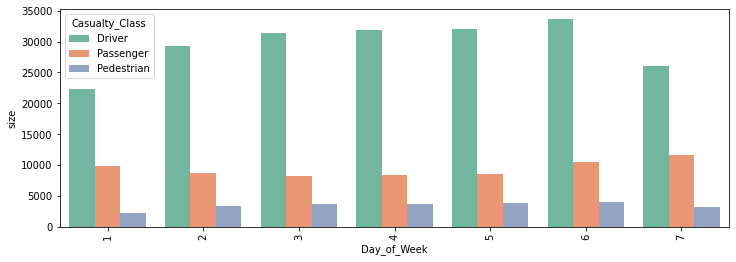

In [15]:
casualty_class={1:'Driver',2:'Passenger',3:'Pedestrian'}
acc_df['Casualty_Class']=acc_df.Casualty_Class.map(casualty_class)
Pedestriansdays = pd.DataFrame(acc_df.groupby([acc_df['Casualty_Class'], acc_df['Day_of_Week']], as_index=False).size())
plt.figure(figsize=(12,4))
sns.barplot(x='Day_of_Week',data=Pedestriansdays,y='size', hue = 'Casualty_Class',palette='Set2')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

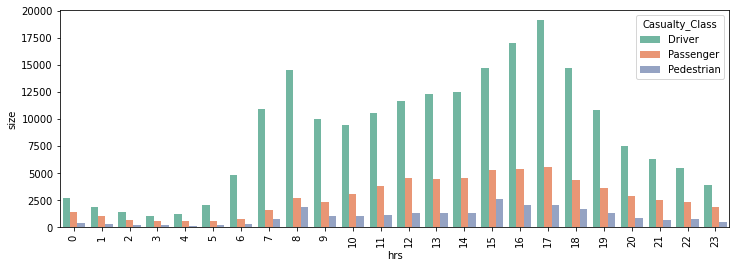

In [16]:
Pedestriansdays = pd.DataFrame(acc_df.groupby([acc_df['Casualty_Class'], acc_df['hrs']], as_index=False).size())
plt.figure(figsize=(12,4))
sns.barplot(x='hrs',data=Pedestriansdays,y='size', hue = 'Casualty_Class',palette='Set2')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

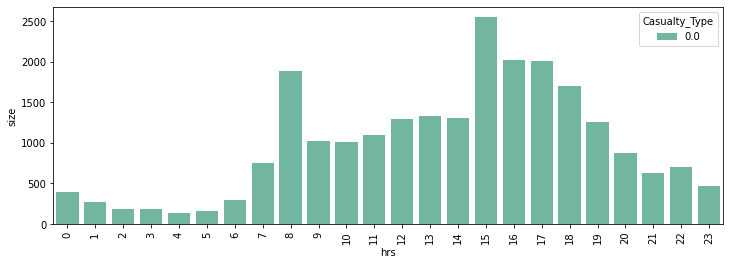

In [17]:
Pedw = pd.DataFrame(acc_df.groupby([acc_df['Casualty_Type'][(acc_df['Casualty_Type']==0)], acc_df['Day_of_Week']], as_index=False).size())
Pedhrs = pd.DataFrame(acc_df.groupby([acc_df['Casualty_Type'][(acc_df['Casualty_Type']==0)], acc_df['hrs']], as_index=False).size())
plt.figure(figsize=(12,4))
sns.barplot(x='hrs',data=Pedhrs,y='size', hue='Casualty_Type', palette='Set2')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7')])

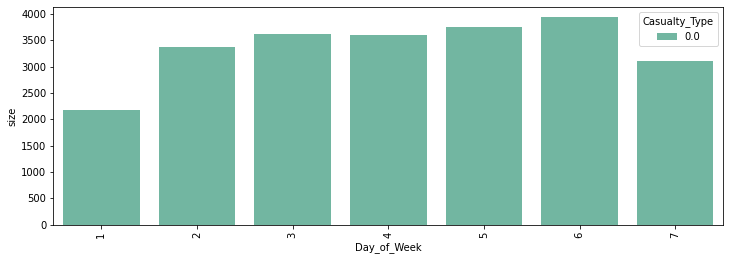

In [18]:
plt.figure(figsize=(12,4))
sns.barplot(x='Day_of_Week',data=Pedw,y='size', hue='Casualty_Type', palette='Set2')
plt.xticks(rotation=90)

#### (d) What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops?

Day Light saving in 2019 occurred at March and October last weeks as seen in the graph those week had a rise in the number of accidents.

Overall in around the year it doesnt show much impact




<AxesSubplot:xlabel='weekofyear', ylabel='size'>

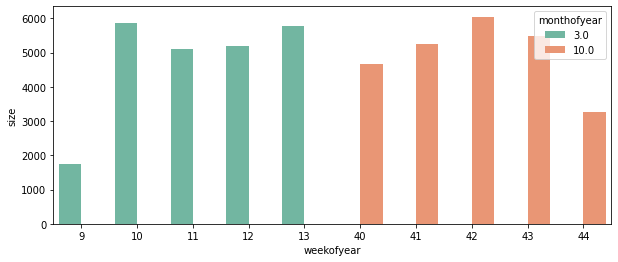

In [19]:
%matplotlib inline
# Number of accident on daylight saving - the month of March and October
day = pd.DataFrame(acc_df.groupby([acc_df['monthofyear'][(acc_df['monthofyear'] == 3) | (acc_df['monthofyear'] == 10)],acc_df['weekofyear']], as_index=False).size())
day
plt.figure(figsize=(10,4))
sns.barplot(x='weekofyear',y='size',data=day, hue='monthofyear', palette='Set2')

#### (e) What impact, if any, does sunrise and sunset times have on road traffic accidents?

Sunrise and sunset doesnt impact on the accidents as most of the accidents occur on the daylight timings
and sunset has the second higher count than sunrise as travelling would be more at the sunset time

##### Data obtained from : 
https://www.worlddata.info/europe/united-kingdom/sunset.php

In [20]:
su = {'monthofyear': [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12], 
      'sunrise': [7.57,7.12,6.12,6.02,5.06,4.40,4.59,5.44,6.33,7.22,7.15,7.57], 
      'sunset':[16.22,17.16,18.6,19.58,20.47,21.21,21.13,20.26,19.17,18.9,16.13,15.53], 
      'daylighthours': [8.25, 10.05, 11.54, 13.56, 15.41, 16.41, 16.15, 14.41, 12.44, 10.47, 8.57, 7.56]}
sun = pd.DataFrame.from_dict(su)

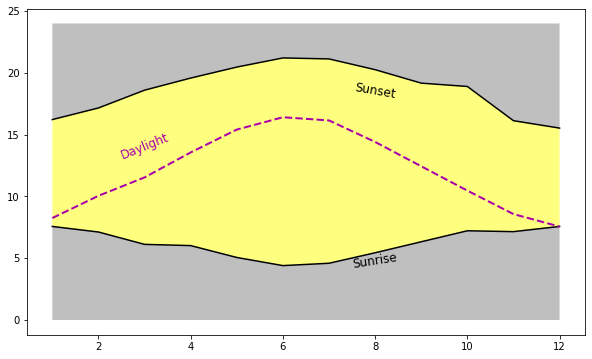

In [21]:
fig, ax =plt.subplots(figsize=(10,6))
plt.fill_between(sun['monthofyear'], sun['sunrise'], sun['sunset'], facecolor='yellow', alpha=.5)
plt.fill_between(sun['monthofyear'], 0, sun['sunrise'], facecolor='black', alpha=.25)
plt.fill_between(sun['monthofyear'], sun['sunset'], 24, facecolor='black', alpha=.25)
plt.plot(sun['monthofyear'],sun['sunrise'], color='k')
plt.plot(sun['monthofyear'], sun['sunset'], color='k')
plt.plot(sun['monthofyear'], sun['daylighthours'], color='#aa00aa', linestyle='--', lw=2)

# Add annotations
ax.text(8, 4.25, 'Sunrise', fontsize=12, color='black', ha='center', rotation=9)
ax.text(8, 18, 'Sunset', fontsize=12, color='black', ha='center', rotation=-10)
ax.text(3, 13, 'Daylight', fontsize=12, color='#aa00aa', ha='center', rotation=22)
plt.show()

In [22]:
def sunrs(month,hrs):
    rmo1 = [1,2,10,11,12]
    rmo2 = [3,4,9]
    rmo3 = [5,6,7,8]
    smo1 = [1,2,11,12]
    smo2 = [3,9,10]
    smo3 = [4,5,6,7,8]
    if month in rmo1 and hrs in range(7,9):
        return 'Sunrise' 
    if month in rmo2 and hrs in range (6,7):
        return 'Sunrise'
    if month in rmo3 and hrs in range (4,6):
        return 'Sunrise'
    if month in smo1 and hrs in range (16,18):
        return 'Sunset'
    if month in smo2 and hrs in range (18,20):
        return 'Sunset'    
    if month in smo3 and hrs in range (20,22):
        return 'Sunset'
    else:
        return 'DayLight'

acc_df['Sun_Rise_Set'] = acc_df.apply(lambda x: sunrs(x.monthofyear, x.hrs), axis=1)


AxesSubplot(0.125,0.125;0.775x0.755)


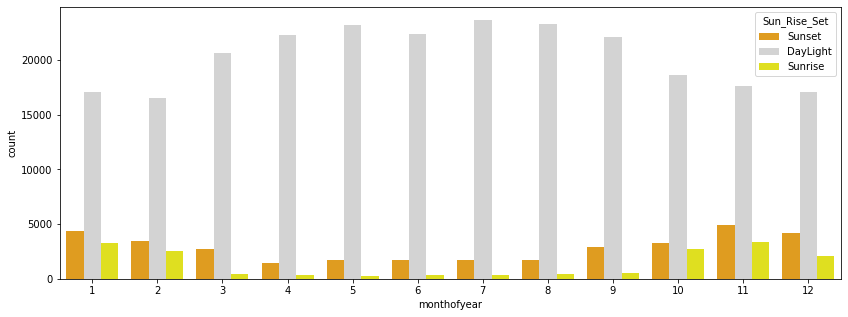

In [23]:
%matplotlib inline
plt.figure(figsize=(14,5))
palette ={"Sunrise": "yellow", "Sunset": "orange", "DayLight": "lightgrey"}
ed = sns.countplot(hue=acc_df['Sun_Rise_Set'], x=acc_df['monthofyear'],palette=palette)
print(ed)

#### (f) Are there particular types of vehicles (engine capacity, age of vehicle, etc.) that are more frequently involved in road traffic accidents?

Most of the aged vehicles involved in accidents are Motorcycles and Cars

Right hand driving was the most of all accidents occured




(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Car'),
  Text(1, 0, 'Pedal cycle'),
  Text(2, 0, 'Taxi/Private hire car'),
  Text(3, 0, 'Van / Goods 3.5 tonnes mgw or under'),
  Text(4, 0, 'Motorcycle over 125cc and up to 500cc'),
  Text(5, 0, 'Motorcycle 125cc and under'),
  Text(6, 0, 'Bus or coach (17 or more pass seats)'),
  Text(7, 0, 'Motorcycle over 500cc'),
  Text(8, 0, 'Motorcycle 50cc and under'),
  Text(9, 0, 'Minibus (8 - 16 passenger seats)'),
  Text(10, 0, 'Mobility scooter'),
  Text(11, 0, 'Motorcycle - unknown cc'),
  Text(12, 0, 'Electric motorcycle'),
  Text(13, 0, 'Goods 7.5 tonnes mgw and over'),
  Text(14, 0, 'Other vehicle'),
  Text(15, 0, 'Goods vehicle - unknown weight'),
  Text(16, 0, 'Data Missing'),
  Text(17, 0, 'Goods over 3.5t. and under 7.5t'),
  Text(18, 0, 'Ridden horse'),
  Text(19, 0, 'Agricultural vehicle'),
  Text(20, 0, 'Tram')])

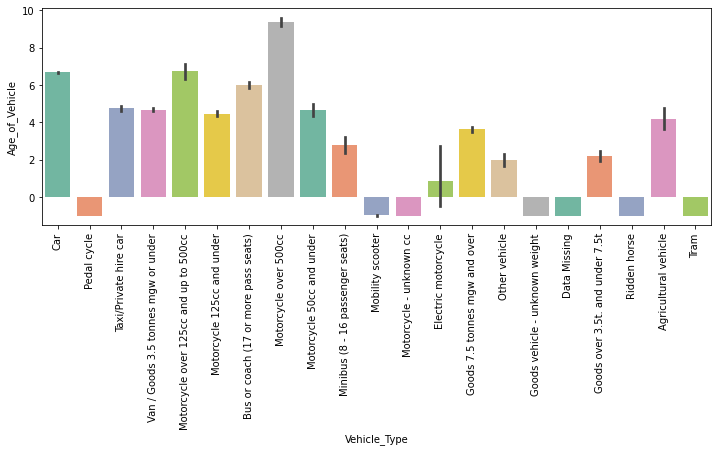

In [24]:
plt.figure(figsize=(12,4))
sns.barplot(x='Vehicle_Type',data=acc_df, y='Age_of_Vehicle', palette='Set2')
plt.xticks(rotation=90)


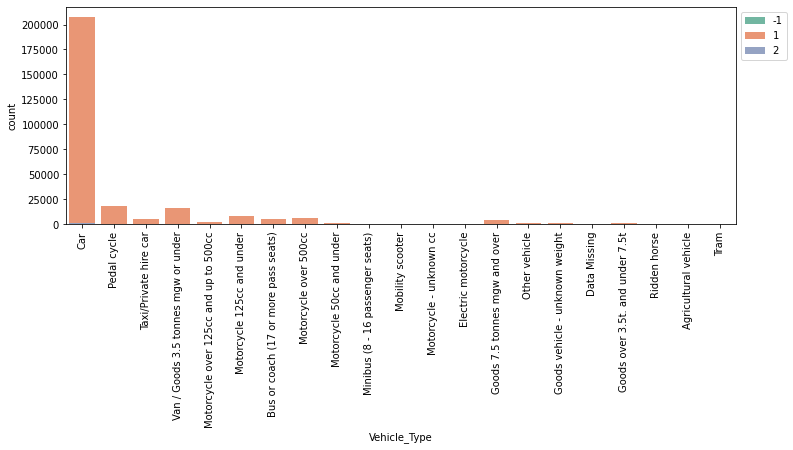

In [25]:
plt.figure(figsize=(12,4))
sns.countplot(x='Vehicle_Type',data=acc_df, hue='Was_Vehicle_Left_Hand_Drive?', palette='Set2',dodge=False)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))
#MOST OF THEM ARE RIGHT HAND 
#1-RIGHT HAND

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Car'),
  Text(1, 0, 'Pedal cycle'),
  Text(2, 0, 'Taxi/Private hire car'),
  Text(3, 0, 'Van / Goods 3.5 tonnes mgw or under'),
  Text(4, 0, 'Motorcycle over 125cc and up to 500cc'),
  Text(5, 0, 'Motorcycle 125cc and under'),
  Text(6, 0, 'Bus or coach (17 or more pass seats)'),
  Text(7, 0, 'Motorcycle over 500cc'),
  Text(8, 0, 'Motorcycle 50cc and under'),
  Text(9, 0, 'Minibus (8 - 16 passenger seats)'),
  Text(10, 0, 'Mobility scooter'),
  Text(11, 0, 'Motorcycle - unknown cc'),
  Text(12, 0, 'Electric motorcycle'),
  Text(13, 0, 'Goods 7.5 tonnes mgw and over'),
  Text(14, 0, 'Other vehicle'),
  Text(15, 0, 'Goods vehicle - unknown weight'),
  Text(16, 0, 'Data Missing'),
  Text(17, 0, 'Goods over 3.5t. and under 7.5t'),
  Text(18, 0, 'Ridden horse'),
  Text(19, 0, 'Agricultural vehicle'),
  Text(20, 0, 'Tram')])

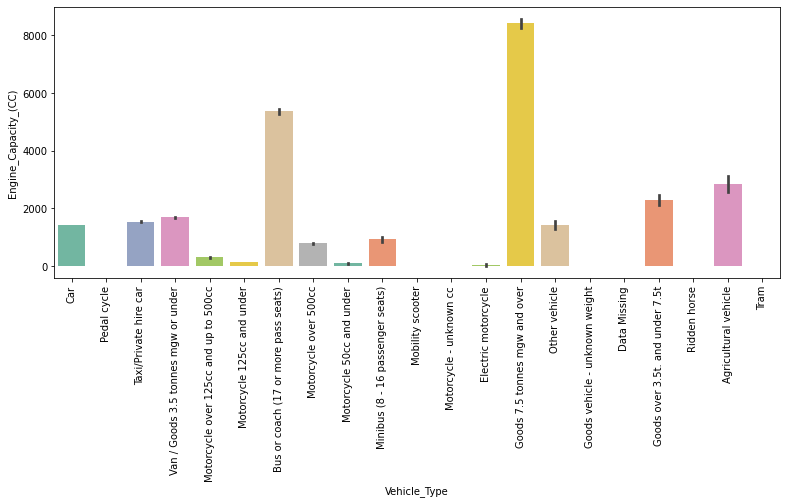

In [26]:
plt.figure(figsize=(13,5))
sns.barplot(data=acc_df, x='Vehicle_Type',y='Engine_Capacity_(CC)', palette='Set2',dodge=False)
plt.xticks(rotation=90)

<Figure size 1080x432 with 0 Axes>

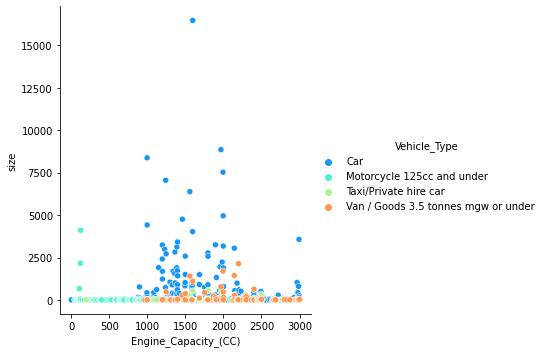

In [27]:
vec = pd.DataFrame(acc_df.groupby([acc_df['Vehicle_Type'], acc_df['Engine_Capacity_(CC)']], as_index=False).size())

vec1 = vec[(vec['Vehicle_Type']=='Car')| (vec['Vehicle_Type']=='Van / Goods 3.5 tonnes mgw or under')
           | (vec['Vehicle_Type']=='Taxi/Private hire car')| (vec['Vehicle_Type']=='Motorcycle 125cc and under')]
vec1 = vec1[vec1['Engine_Capacity_(CC)'].between(left=1, right=3000)]
plt.figure(figsize=(15,6))
sns.relplot(data=vec1, hue='Vehicle_Type',x='Engine_Capacity_(CC)',y='size', palette='rainbow')

In [28]:
vec1['size'].max()

16468

#### (g) Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?

Weather Conditions

Text(0.5, 1.0, 'Weather based on severity')

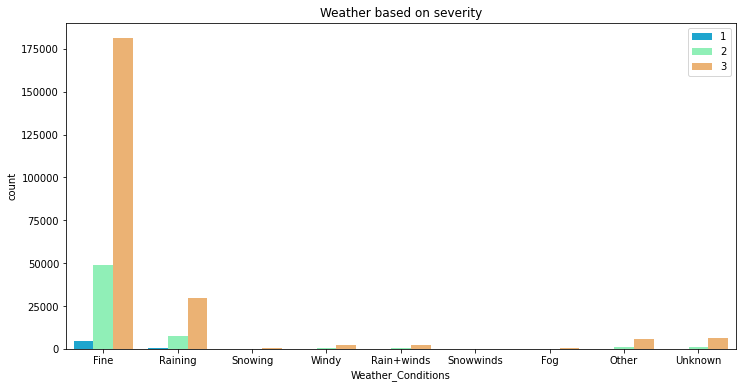

In [29]:

plt.figure(figsize=(12,6))
sns.countplot(x='Weather_Conditions',data=acc_df, hue='Accident_Severity', palette='rainbow')
plt.xticks([0,1,2,3,4,5,6,7,8],['Fine','Raining','Snowing','Windy','Rain+winds','Snowwinds','Fog','Other','Unknown'])
plt.legend(bbox_to_anchor=(1,1))
plt.title('Weather based on severity')

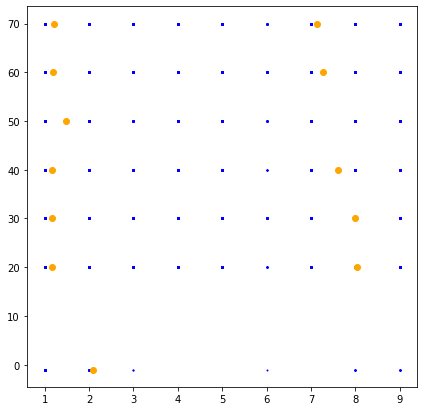

In [30]:
ws = acc_df[['Speed_limit','Weather_Conditions']]
kmeans=KMeans(n_clusters=12)
kmeans.fit(ws)
kmeans.inertia_
labels=kmeans.predict(ws)
centroids=kmeans.cluster_centers_
fig = plt.figure(figsize=(7,7))
colors=map(lambda x: colmap[x+1],labels)
plt.scatter(ws['Weather_Conditions'], ws['Speed_limit'], color='blue',s=1)
plt.scatter(centroids[:,1],centroids[:,0],color='orange')
plt.show()

In [31]:
ls = acc_df[['Accident_Severity','Light_Conditions','Weather_Conditions']]
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
for n in n_clusters:
    est = KMeans(n_clusters=n, init='k-means++').fit(ls)
    clusters_inertia.append(est.inertia_)    # data for the elbow method


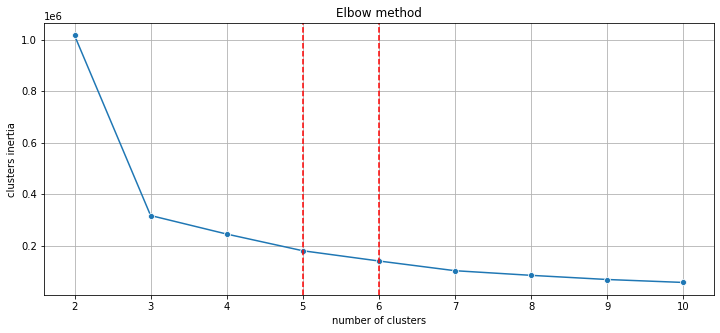

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

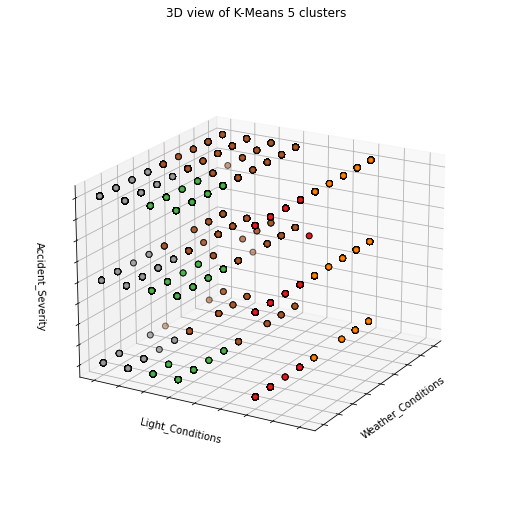

In [33]:
clusters = KMeans(n_clusters=5, init='k-means++').fit(ls) # initialise and fit K-Means model
cluster5 = ls.copy()
cluster5.loc[:,'Cluster'] = clusters.labels_
KM_sizes = cluster5.groupby('Cluster').size().to_frame()
KM_sizes.columns = ["KM_size"]
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(cluster5['Weather_Conditions'],
           cluster5['Light_Conditions'],
           cluster5['Accident_Severity'],
           c=cluster5['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Weather_Conditions')
ax.set_ylabel('Light_Conditions')
ax.set_zlabel('Accident_Severity')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12
plt.show()

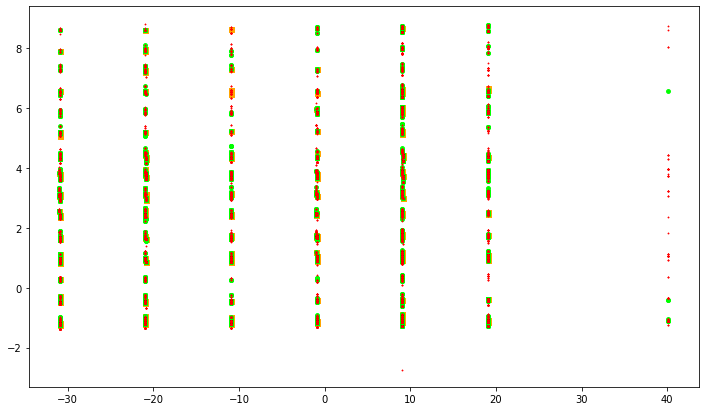

In [34]:
features = ['Weather_Conditions', 'Speed_limit', 'Road_Surface_Conditions', 'Light_Conditions']
target = ['Accident_Severity']
x = acc_df.loc[:, features].values
y = acc_df.loc[:, target].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf1 = pd.concat([principalDf, acc_df[target]], axis = 1)
one = finalDf1[finalDf1['Accident_Severity'] == 1]
two = finalDf1[finalDf1['Accident_Severity'] == 2]
three = finalDf1[finalDf1['Accident_Severity'] == 3]
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
ax1.scatter(one['principal component 1'], one['principal component 2'], color='orange',s=25, marker='s')
ax1.scatter(two['principal component 1'], two['principal component 2'], color='lime',s=15)
ax1.scatter(three['principal component 1'], three['principal component 2'], color='red',s=1, marker='*')
plt.show()

Locations

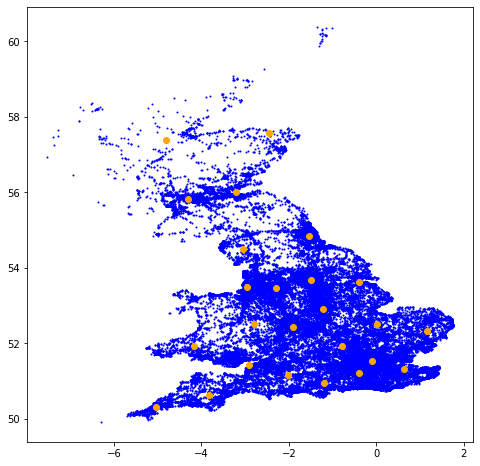

In [35]:
gc = pd.read_csv(Accidents, usecols=["Longitude","Latitude"])
gc=gc.dropna().reset_index(drop=True)
kmeans=KMeans(n_clusters=25)
kmeans.fit(gc)
kmeans.inertia_
labels=kmeans.predict(gc)
centroids=kmeans.cluster_centers_
fig = plt.figure(figsize=(8,8))
colors=map(lambda x: colmap[x+1],labels)
plt.scatter(gc['Longitude'], gc['Latitude'],color='blue', s=1)
plt.scatter(centroids[:,0],centroids[:,1],color='orange')
plt.show()

In [36]:
acc_df['Local_Authority_(District)'].value_counts()

300    7060
204    3759
596    2998
1      2919
9      2491
       ... 
57       70
915      63
941      45
933      43
936      37
Name: Local_Authority_(District), Length: 380, dtype: int64

Based on the above figure it is evident that most of the accidents occur at the denser blue part of the map . On analysing we could see the districts such as in and around london and Birmingham are facing most of the accidents

(array([  1,  70, 204, 300, 596, 500, 570]),
 [Text(1, 0, '1,3,9-Westminster'),
  Text(70, 0, '12,13Waltham'),
  Text(204, 0, 'Leeds'),
  Text(300, 0, 'Birmingham'),
  Text(596, 0, 'Southampton'),
  Text(500, 0, 'City of London'),
  Text(570, 0, 'Cornwall')])

<Figure size 936x576 with 0 Axes>

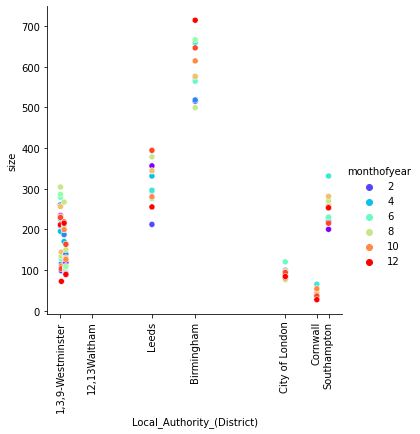

In [37]:
%matplotlib inline
# Number of accident on daylight saving - the month of March and October
ld = [1,3,9,12,13,204,300,596,500,570]

mld = pd.DataFrame(acc_df.groupby([acc_df['Local_Authority_(District)'][(acc_df['Local_Authority_(District)'].isin(ld))],
                                   acc_df['monthofyear']], as_index=False).size())
plt.figure(figsize=(13,8))
sns.relplot(x='Local_Authority_(District)',y='size',data=mld, hue='monthofyear', palette='rainbow')
plt.xticks([1,70,204,300,596,500,570],['1,3,9-Westminster','12,13Waltham','Leeds',
                                              'Birmingham','Southampton','City of London','Cornwall'])
plt.xticks(rotation=90)

#### (h) How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?

([<matplotlib.axis.XTick at 0x22b320716a0>,
 [Text(0, 0, 'Unknown'),
  Text(1, 0, 'Urban'),
  Text(2, 0, 'Town'),
  Text(3, 0, 'Rural')])

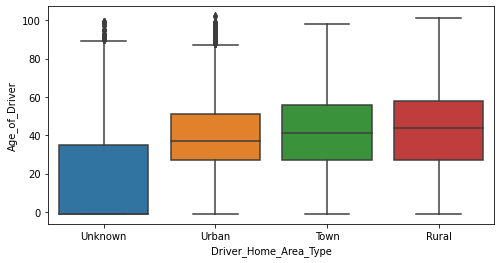

In [38]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Driver_Home_Area_Type',y='Age_of_Driver',data=acc_df)
plt.xticks([0,1,2,3],['Unknown','Urban','Town','Rural'])


Text(0.5, 1.0, 'Journey Purpose of Driver vs Age_of_Driver')

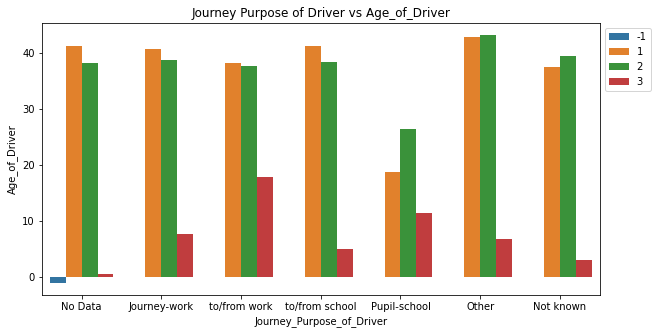

In [39]:
plt.figure(figsize=(10,5))

sns.barplot(x='Journey_Purpose_of_Driver',y='Age_of_Driver',hue='Sex_of_Driver',data=acc_df,ci=None)
plt.xticks([0,1,2,3,4,5,6],['No Data','Journey-work','to/from work','to/from school',
                             'Pupil-school',
                             'Other','Not known'])

plt.legend(bbox_to_anchor=(1,1))
plt.title('Journey Purpose of Driver vs Age_of_Driver')

# 1-Male 2-female
# So most of them were right hand from the below image

<Figure size 720x288 with 0 Axes>

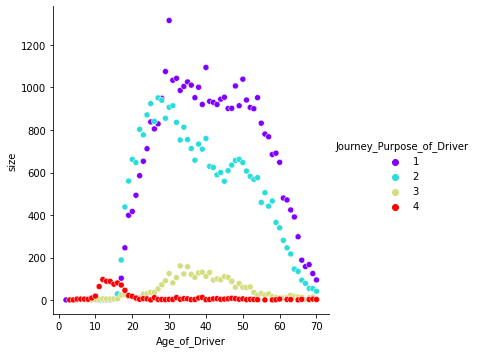

In [40]:
jour = pd.DataFrame(acc_df.groupby([acc_df['Journey_Purpose_of_Driver'], acc_df['Age_of_Driver']], as_index=False).size())
jour = jour[jour['Journey_Purpose_of_Driver'].between(left=1, right=4)]
jour = jour[jour['Age_of_Driver'].between(left=1, right=70)]
plt.figure(figsize=(10,4))
sns.relplot(data=jour, hue='Journey_Purpose_of_Driver',x='Age_of_Driver',y='size', palette='rainbow')
# 1	Journey as part of work
# 2	Commuting to/from work
# 3	Taking pupil to/from school - persons involved in dropping or picking of pupils
# 4	Pupil riding to/from school - school going pupils



#### (i) Can we make predictions about when and where accidents will occur, and the severity of the injuries sustained from the data supplied to improve road safety? How well do our models compare to government models? 

#### KBEST FEATURE EXTRACTION

range(0, 6) [ 3.50019394         inf  0.52063779 88.13516817  1.11954299  4.32589461]


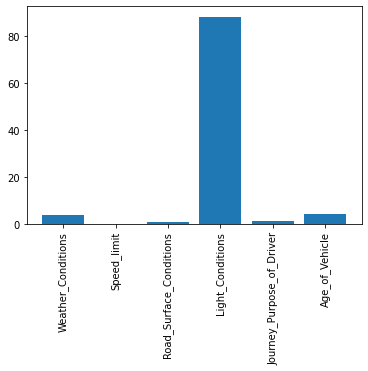

In [41]:
predictors2 = ["Weather_Conditions", "Speed_limit", "Road_Surface_Conditions", "Light_Conditions",'Journey_Purpose_of_Driver','Age_of_Vehicle']

kbest_df = acc_df[(acc_df['Weather_Conditions']>0) & 
                  (acc_df['Speed_limit']>0) & 
                  (acc_df['Road_Surface_Conditions']>0) & 
                  (acc_df['Light_Conditions']>0) &  
                  (acc_df['Journey_Purpose_of_Driver']>0) &  
                  (acc_df['Age_of_Vehicle']>0) &  
                 (acc_df['Accident_Severity'])]
# Perform the feature selection
selector2 = SelectKBest(f_classif, k="all")
selector2.fit(kbest_df[predictors2], kbest_df["Accident_Severity"])
import numpy as np
# Here we will get the p-values for each feature and then transform from p-values into some scores
scores = -np.log10(selector2.pvalues_)
print(range(len(predictors2)),scores)
# Use plt to plot the scores!  
plt.bar(range(len(predictors2)), scores)
plt.xticks(range(len(predictors2)), predictors2, rotation='vertical')
plt.show()

#### APRIORI AND ASSOCIATE PATTERN MINING

In [42]:
apm1=pd.get_dummies(acc_df['Pedestrian_Crossing-Physical_Facilities'], prefix='Pedes_Cross')
apm2=pd.get_dummies(acc_df['Speed_limit'], prefix='Speed_limit')
apm3=pd.get_dummies(acc_df['Accident_Severity'], prefix='Accident_Sever')
apm4=pd.get_dummies(acc_df['Weather_Conditions'], prefix='Weather')
apm5=pd.get_dummies(acc_df['Light_Conditions'], prefix='light')
apmlist=[apm1,apm2,apm3,apm4,apm5]
apm = pd.concat(apmlist, axis=1)
apm.head()

,Pedes_Cross_-1,Pedes_Cross_0,Pedes_Cross_1,Pedes_Cross_4,Pedes_Cross_5,Pedes_Cross_7,Pedes_Cross_8,Speed_limit_-1,Speed_limit_20,Speed_limit_30,...,Weather_6,Weather_7,Weather_8,Weather_9,light_-1,light_1,light_4,light_5,light_6,light_7
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [43]:
# Building the model
freq = apriori(apm,min_support=0.2,use_colnames=True)
# Collecting the inferred rules in a dataframe
rules = association_rules(freq, metric ="lift", min_threshold = 0.5)
rules.sort_values("lift", ascending = False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
140,"(Accident_Sever_3, Weather_1)","(Speed_limit_30, light_1)",0.613146,0.380443,0.259873,0.423836,1.114058,0.026606,1.075313
145,"(Speed_limit_30, light_1)","(Accident_Sever_3, Weather_1)",0.380443,0.613146,0.259873,0.683080,1.114058,0.026606,1.220668
143,"(Weather_1, Speed_limit_30)","(Accident_Sever_3, light_1)",0.428457,0.561748,0.259873,0.606532,1.079722,0.019188,1.113817
142,"(Accident_Sever_3, light_1)","(Weather_1, Speed_limit_30)",0.561748,0.428457,0.259873,0.462615,1.079722,0.019188,1.063562
122,"(Accident_Sever_3, Weather_1, Pedes_Cross_0)",(light_1),0.484020,0.714625,0.369448,0.763291,1.068101,0.023556,1.205597
...,...,...,...,...,...,...,...,...,...
111,"(Weather_1, Pedes_Cross_0, light_1)",(Speed_limit_30),0.481831,0.539013,0.235670,0.489113,0.907423,-0.024043,0.902326
25,(Pedes_Cross_0),"(Accident_Sever_3, Speed_limit_30)",0.797777,0.436624,0.315652,0.395664,0.906189,-0.032677,0.932223
20,"(Accident_Sever_3, Speed_limit_30)",(Pedes_Cross_0),0.436624,0.797777,0.315652,0.722936,0.906189,-0.032677,0.729881
34,"(Pedes_Cross_0, light_1)",(Speed_limit_30),0.575985,0.539013,0.280649,0.487251,0.903969,-0.029814,0.899050


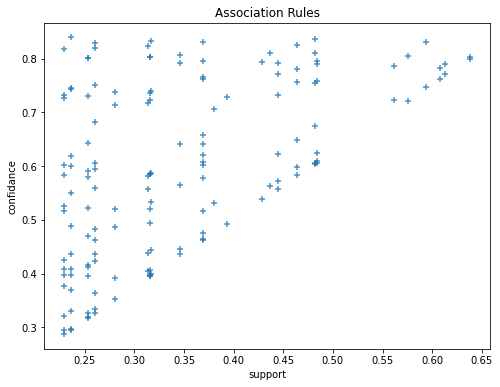

In [44]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()
for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]
plt.figure(figsize=(8,6))    
plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidance')
sns.regplot(x=support, y=confidence, fit_reg=False, marker="+")
plt.show()

In [45]:
r_rules = rules[ (rules['lift'] > 1) & (rules['confidence'] >= 0.5) ]
# Find Patterns 
col_keep = {'antecedents':'item_1', 'consequents':'item_2', 'support':'support', 'confidence':'confidence', 'lift':'lift'}
col_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']
pattern = pd.DataFrame(r_rules).rename(columns= col_keep).drop(columns=col_drop).sort_values(by=['lift'], ascending = False)
display(pattern)

,item_1,item_2,support,confidence,lift
145,"(Speed_limit_30, light_1)","(Accident_Sever_3, Weather_1)",0.259873,0.683080,1.114058
143,"(Weather_1, Speed_limit_30)","(Accident_Sever_3, light_1)",0.259873,0.606532,1.079722
122,"(Accident_Sever_3, Weather_1, Pedes_Cross_0)",(light_1),0.369448,0.763291,1.068101
135,(light_1),"(Accident_Sever_3, Weather_1, Pedes_Cross_0)",0.369448,0.516982,1.068101
64,"(Speed_limit_30, light_1)",(Accident_Sever_3),0.313446,0.823897,1.061784
...,...,...,...,...,...
42,(Weather_1),"(Accident_Sever_3, Pedes_Cross_0)",0.484020,0.609346,1.002974
39,"(Accident_Sever_3, Pedes_Cross_0)",(Weather_1),0.484020,0.796688,1.002974
141,"(Accident_Sever_3, Speed_limit_30)","(Weather_1, light_1)",0.259873,0.595187,1.001649
11,(Speed_limit_30),(Weather_1),0.428457,0.794892,1.000713


###### PATTERNS FOUND
Based on the above patterns we could say that the maximum accidents with severity 3 occur with light -1 (Daylight), Speedlimit -30 , weather - 1 (Fine) 

##### MODELS & PREDICTION

In [46]:
def get_stacking():
    level0 = list()
    level0.append(('dtree', DecisionTreeClassifier()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('lr', LogisticRegression()))
    level0.append(('bayes', GaussianNB()))
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['lr'] = LogisticRegression()
    models['bayes'] = GaussianNB()
    models['Stacked'] = get_stacking()
    return models

In [47]:
features = ['Weather_Conditions', 'Speed_limit', 'Road_Surface_Conditions', 'Light_Conditions','Age_of_Vehicle','Journey_Purpose_of_Driver']
target = ['Accident_Severity']

mod = acc_df.filter(['Weather_Conditions','Speed_limit','Road_Surface_Conditions', 'Light_Conditions', 'Accident_Severity', 'Age_of_Vehicle','Journey_Purpose_of_Driver'], axis=1)
modnow = mod[(mod['Weather_Conditions']>0) & (mod['Speed_limit']>0) & (mod['Road_Surface_Conditions']>0) & 
             (mod['Light_Conditions']>0) & (mod['Age_of_Vehicle']>0) & (mod['Journey_Purpose_of_Driver']>0)]

y_target = modnow["Accident_Severity"].values
Xfeatures = modnow.drop("Accident_Severity", axis=1)
# The new bit is to use test-train split like so:
def get_dataset():
    X_train, X_validation, y_train, y_validation = train_test_split(Xfeatures,y_target,test_size=.25,random_state=1)
    return X_train, y_train

In [48]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
#Grab hold of the dataset.
X, y = get_dataset()
#Grab the models to use.
models = get_models()
#Run and Evaluate the models.
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>dtree 0.771 (0.002)
>knn 0.738 (0.003)
>lr 0.773 (0.000)
>bayes 0.768 (0.001)
>Stacked 0.776 (0.001)


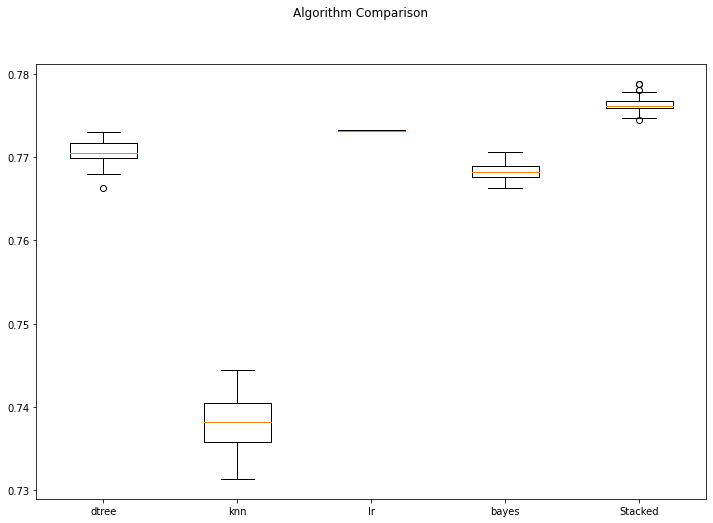

In [49]:
fig = plt.figure(figsize=(12,8)) 
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [50]:
X_train, X_validation, y_train, y_validation = train_test_split(Xfeatures,y_target,test_size=.25,random_state=1)
lr = LogisticRegression()
lr.fit(X_train,y_train)
Y_pred = lr.predict(X_validation)
lr.score(X_validation, y_validation)
acc_lr = round(lr.score(X_validation, y_validation) * 100, 2)

report = classification_report(
    digits=3,
    y_true=y_validation, 
    y_pred=Y_pred)
print("Accuracy" , acc_lr)
print(report)
pd.crosstab(y_validation, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 77.56
              precision    recall  f1-score   support

           1      0.000     0.000     0.000      1184
           2      0.000     0.000     0.000     11040
           3      0.776     1.000     0.874     42252

    accuracy                          0.776     54476
   macro avg      0.259     0.333     0.291     54476
weighted avg      0.602     0.776     0.678     54476



Predicted,2,3,All
Actual,,,
1,0,1184,1184
2,0,11040,11040
3,1,42251,42252
All,1,54475,54476


##### GOVERNMENT MODELS AND EXAMINATION OF THE CAS ADJUSTMENTS

In [51]:
Sev2_19=df4['Adjusted_Serious'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2019'))].count()
Sev3_19=df4['Adjusted_Slight'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2019'))].count()
Inj_19=df4['Injury_Based'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2019'))].count()

Sev2_14=df4['Adjusted_Serious'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2017'))].count()
Sev3_14=df4['Adjusted_Slight'][(df4['Adjusted_Slight'] == 1.0) & (df4['accident_index'].str.startswith('2017'))].count()
Inj_14=df4['Injury_Based'][(df4['Injury_Based'] == 1.0) & (df4['accident_index'].str.startswith('2017'))].count()

Sev2_10=df4['Adjusted_Serious'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2015'))].count()
Sev3_10=df4['Adjusted_Slight'][(df4['Adjusted_Slight'] == 1.0) & (df4['accident_index'].str.startswith('2015'))].count()
Inj_10=df4['Injury_Based'][(df4['Injury_Based'] == 1.0) & (df4['accident_index'].str.startswith('2015'))].count()

Sev2_5=df4['Adjusted_Serious'][(df4['Adjusted_Serious'] == 1.0) & (df4['accident_index'].str.startswith('2013'))].count()
Sev3_5=df4['Adjusted_Slight'][(df4['Adjusted_Slight'] == 1.0) & (df4['accident_index'].str.startswith('2013'))].count()
Inj_5=df4['Injury_Based'][(df4['Injury_Based'] == 1.0) & (df4['accident_index'].str.startswith('2013'))].count()

sev2=[Sev2_19,Sev2_14,Sev2_10,Sev2_5]
sev3=[Sev3_19,Sev3_14,Sev3_10,Sev3_5]
inj=[Inj_19,Inj_14,Inj_10,Inj_5]
govt_list = pd.DataFrame(
    {'sev2': sev2,
     'sev3': sev3,
     'Inj': inj,
     'year':[2019,2017,2015,2013]
    })

Text(2019, 60000, 'DownTrend')

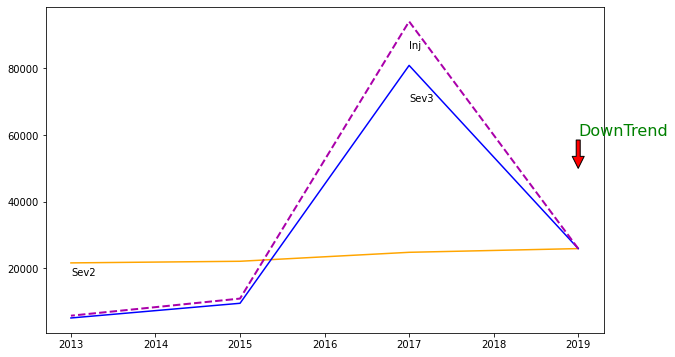

In [52]:
fig, ax =plt.subplots(figsize=(10,6))
plt.plot(govt_list['year'],govt_list['sev2'], color='orange')
plt.text(2013,18000,'Sev2')
plt.plot(govt_list['year'],govt_list['sev3'], color='blue')
plt.text(2017,70000,'Sev3')
plt.plot(govt_list['year'],govt_list['Inj'], color='#aa00aa', linestyle='--', lw=2)
plt.text(2017,86000,'Inj')
plt.annotate('DownTrend', xy = (2019, 50000), 
             fontsize = 16, xytext = (2019, 60000), 
             arrowprops = dict(facecolor = 'red'),
             color = 'g')

In [53]:
newacc=acc_df.filter(['Accident_Index','Weather_Conditions','Speed_limit','Road_Surface_Conditions', 'Light_Conditions', 
                      'Accident_Severity','Journey_Purpose_of_Driver','Age_of_Vehicle'], axis=1)
newaccnow = newacc[(newacc['Weather_Conditions']>0) & (newacc['Speed_limit']>0) & (newacc['Road_Surface_Conditions']>0) & 
                   (newacc['Light_Conditions']>0) & (newacc['Age_of_Vehicle']>0) & (newacc['Journey_Purpose_of_Driver']>0) & 
                   (newacc['Accident_Severity']!=1)]
df4.rename(columns = {'accident_index':'Accident_Index'}, inplace = True)
newaccnow = newaccnow.merge(df4,on='Accident_Index')
newaccnow = newaccnow[newaccnow['Accident_Index'].str.startswith('2019')]
newaccnow['Govt_Pred_Accident_Severity'] = np.where(newaccnow['Adjusted_Serious'] > newaccnow['Adjusted_Slight'], 2,3)

In [54]:
# %matplotlib inline
gv_acc = newaccnow['Govt_Pred_Accident_Severity'].value_counts().rename_axis('Govt_Pred_Accident_Severity').reset_index(name='gv_counts')
acc= newaccnow['Accident_Severity'].value_counts().rename_axis('Accident_Severity').reset_index(name='acc_counts')
gv_acc=gv_acc.join(acc)
gv_acc

,Govt_Pred_Accident_Severity,gv_counts,Accident_Severity,acc_counts
0,3,357533,3,309201
1,2,57034,2,105366


In [55]:
scale = StandardScaler()   
X_train, X_validation, y_train, y_validation = train_test_split(Xfeatures,y_target,test_size=.25,random_state=1)

X_train = scale.fit_transform(X_train)
X_validation = scale.transform(X_validation)

lr = LogisticRegression()
lr.fit(X_train,y_train)
Y_pred = lr.predict(X_validation)
lr.score(X_validation, y_validation)
acc_lr = round(lr.score(X_validation, y_validation) * 100, 2)

report = classification_report(
    digits=3,
    y_true=y_validation, 
    y_pred=Y_pred)
print("Accuracy" , acc_lr)
print(report)
pd.crosstab(y_validation, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


Accuracy 77.56
              precision    recall  f1-score   support

           1      0.000     0.000     0.000      1184
           2      0.000     0.000     0.000     11040
           3      0.776     1.000     0.874     42252

    accuracy                          0.776     54476
   macro avg      0.259     0.333     0.291     54476
weighted avg      0.602     0.776     0.678     54476



Predicted,3,All
Actual,,
1,1184,1184
2,11040,11040
3,42252,42252
All,54476,54476


In [56]:
print('Obtained accuracy for the govt over Accident is',metrics.accuracy_score(newaccnow['Govt_Pred_Accident_Severity'],newaccnow['Accident_Severity']))

Obtained accuracy for the govt over Accident is 0.8830442365166548
